# Lab | Clustering songs

## Introduction

Now it's time to cluster the songs of the **hot_songs** and **not_hot_songs** databases according to the song's audio features. For this purpose, you need to consider the following questions:

* Are you going to use all the audio features? I
  * If not, which ones do you think that makes more sense to be used?
  * It might make sense to use a dimensionality reduction technique to visualize the songs with only two features?
* What is the optimal number of clusters (for methods that need to know this beforehand)?
* What is the best distance to use?
* What clustering method provides better results?
* Does the clustering method need a transformer?

## Considerations

Be aware that this process is extremely time-consuming!!! (it might take several hours on your laptop). Therefore, when testing different options, save the models into your disk in order to be able to use the best model later.  You don't want to retrain the best model again when you know what are the optimal parameters for each.

To determine which clustering method performs best, you need to be practical and think about how many clusters you might want to have alongside with a [clustering metric](https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/) to evaluate how good or bad the songs were clustered.
If the number of clusters is small, each cluster will be too big and generic. On the contrary, if the number of clusters is too big then each cluster will be too specific and it will be poorly populated (this also depends on how heterogeneous is your dataset).

On the other hand, when you train your clustering model make sure to concatenate both databases together (ie: **hot_songs** and **not_hot_songs**) before. 
If you don't combine both datasets, the clusters obtained with the **hot_songs** will be different than the ones obtained with the **not_hot_songs**
database even though they might have the same label because they will contain different songs. However, after this, you will not know to which original
dataframe belongs each song. To prevent this problem, before the concatenation you can add a new column named "dataset" with a "flag" to remind yourself in which dataset was included ("Hot", "Not hot")
each song. 

Finally, add a new column to the full dataset **for each clustering method with the cluster membership of each song** 

In [204]:
%conda install conda-forge::scikit-learn=1.3.2 -y

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /Users/minhnguyen/anaconda3

  added / updated specs:
    - conda-forge::scikit-learn=1.3.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-1.3.2         |  py311h66081b9_2         8.4 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.4 MB

The following packages will be UPDATED:

  scikit-learn                        1.3.1-py311h66081b9_1 --> 1.3.2-py311h66081b9_2 



                                                         

In [ ]:
%conda config --append channels conda-forge

In [2]:
%conda install conda-forge::kneed -y

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
# import libraries

# folder location
import sys
sys.path.append('/Users/minhnguyen/IronHack2023-2024/Bootcamp')

# standard
import pandas as pd
import numpy as np

# dimensionality reduction and cluster modelling
#from sklearn.datasets import make_classification
#from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from kneed import KneeLocator

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import time
import pickle
#from dbcv import *



In [2]:
extended_hot_song = pd.read_csv('/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/6.2_lab-spotify-api/extended_hot_song.csv')
extended_not_hot_song = pd.read_csv('/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/6.2_lab-spotify-api/extended_not_hot_song.csv')

In [4]:
extended_hot_song_clean = extended_hot_song.drop(columns = ['Unnamed: 0'])

In [6]:
extended_not_hot_song_clean = extended_not_hot_song.drop(columns = ['Unnamed: 0', 'level_0', 'index'])

In [7]:
extended_hot_song_clean['hotness'] = 'yes'
extended_not_hot_song_clean['hotness'] = 'no'

In [8]:
extended_hot_song_clean = extended_hot_song_clean.rename(columns = {"Song_title":"track_name", 'Artist':'artist_name'})

In [9]:
# concatenate hot songs and not hot song dataframe
song_db = pd.concat([extended_hot_song_clean, extended_not_hot_song_clean], axis=0)

#saving new dataframe to csv
song_db.to_csv('song_db.csv', index=False)

In [10]:
song_db = pd.read_csv('song_db.csv')

In [11]:
song_db

,track_name,artist_name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,hotness
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.614000,...,0.898,67.196,audio_features,2EjXfH91m7f8HiJN1yQg97,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,yes
1,All I Want For Christmas Is You,Mariah Carey,0bYg9bo50gSsH3LtXe2SQn,0.336,0.627,7,-7.463,1,0.0384,0.164000,...,0.350,150.273,audio_features,0bYg9bo50gSsH3LtXe2SQn,spotify:track:0bYg9bo50gSsH3LtXe2SQn,https://api.spotify.com/v1/tracks/0bYg9bo50gSs...,https://api.spotify.com/v1/audio-analysis/0bYg...,241107,4,yes
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.643000,...,0.806,119.705,audio_features,7vQbuQcyTflfCIOu3Uzzya,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,yes
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.189000,...,0.947,107.682,audio_features,2FRnf9qhLbvw8fu4IBXx78,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,yes
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.579000,...,0.888,140.467,audio_features,77khP2fIVhSW23NwxrRluh,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,reckless life,guns n' roses,7I2Q7AQqVInZYwOoDHZGOf,0.442,0.888,10,-8.820,0,0.0663,0.000054,...,0.462,108.024,audio_features,7I2Q7AQqVInZYwOoDHZGOf,spotify:track:7I2Q7AQqVInZYwOoDHZGOf,https://api.spotify.com/v1/tracks/7I2Q7AQqVInZ...,https://api.spotify.com/v1/audio-analysis/7I2Q...,200600,4,no
2803,pain and love,t. rex,5Qe7x9x8mfl2YcbYTP5yRM,0.588,0.629,0,-10.226,0,0.0318,0.055500,...,0.763,136.091,audio_features,5Qe7x9x8mfl2YcbYTP5yRM,spotify:track:5Qe7x9x8mfl2YcbYTP5yRM,https://api.spotify.com/v1/tracks/5Qe7x9x8mfl2...,https://api.spotify.com/v1/audio-analysis/5Qe7...,221440,4,no
2804,brave new world,greta van fleet,0HwdiT4MVRzY0OALcjq0Oh,0.341,0.848,7,-4.475,1,0.0371,0.058300,...,0.589,136.568,audio_features,0HwdiT4MVRzY0OALcjq0Oh,spotify:track:0HwdiT4MVRzY0OALcjq0Oh,https://api.spotify.com/v1/tracks/0HwdiT4MVRzY...,https://api.spotify.com/v1/audio-analysis/0Hwd...,300880,4,no
2805,i-76,g. love & special sauce,40c4Zo0r2HH9aKDgEsbsVA,0.643,0.713,11,-6.716,0,0.2150,0.138000,...,0.492,103.942,audio_features,40c4Zo0r2HH9aKDgEsbsVA,spotify:track:40c4Zo0r2HH9aKDgEsbsVA,https://api.spotify.com/v1/tracks/40c4Zo0r2HH9...,https://api.spotify.com/v1/audio-analysis/40c4...,225640,4,no


# Exploring audio features

In [13]:
song_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2807 entries, 0 to 2806
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        2807 non-null   object 
 1   artist_name       2807 non-null   object 
 2   song_id           2807 non-null   object 
 3   danceability      2807 non-null   float64
 4   energy            2807 non-null   float64
 5   key               2807 non-null   int64  
 6   loudness          2807 non-null   float64
 7   mode              2807 non-null   int64  
 8   speechiness       2807 non-null   float64
 9   acousticness      2807 non-null   float64
 10  instrumentalness  2807 non-null   float64
 11  liveness          2807 non-null   float64
 12  valence           2807 non-null   float64
 13  tempo             2807 non-null   float64
 14  type              2807 non-null   object 
 15  id                2807 non-null   object 
 16  uri               2807 non-null   object 


In [105]:
song_db.select_dtypes(np.number).describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,2807.000000,2807.000000,2807.000000,2807.000000,2807.000000,2807.000000,2807.000000,2807.000000,2807.000000,2807.000000,2807.000000,2.807000e+03,2807.000000
mean,0.556468,0.578064,5.309227,-9.480302,0.713929,0.069169,0.328512,0.077468,0.196277,0.539839,120.320267,2.285655e+05,3.898468
std,0.160419,0.235868,3.562875,4.083253,0.452003,0.075567,0.320769,0.207784,0.168272,0.244854,29.515326,8.748128e+04,0.389667
min,0.099400,0.009360,0.000000,-33.424000,0.000000,0.022600,0.000001,0.000000,0.019200,0.036800,38.498000,3.922700e+04,1.000000
25%,0.446000,0.393000,2.000000,-12.056500,0.000000,0.032100,0.032150,0.000000,0.094650,0.343000,97.031000,1.752930e+05,4.000000
50%,0.559000,0.593000,5.000000,-8.937000,1.000000,0.041000,0.215000,0.000074,0.127000,0.548000,118.303000,2.156270e+05,4.000000
75%,0.667500,0.770000,9.000000,-6.329500,1.000000,0.067700,0.612500,0.008260,0.245000,0.736000,139.961000,2.603860e+05,4.000000
max,0.958000,0.997000,11.000000,-0.734000,1.000000,0.914000,0.995000,0.960000,0.987000,0.984000,209.034000,1.815107e+06,5.000000


In [106]:
song_db.select_dtypes(np.number)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.589,0.472,8,-8.749,1,0.0502,0.614000,0.000000,0.5050,0.898,67.196,126267,4
1,0.336,0.627,7,-7.463,1,0.0384,0.164000,0.000000,0.0708,0.350,150.273,241107,4
2,0.754,0.424,2,-8.463,1,0.0363,0.643000,0.000000,0.0652,0.806,119.705,130973,4
3,0.735,0.478,2,-12.472,1,0.0293,0.189000,0.000002,0.3550,0.947,107.682,262960,4
4,0.683,0.375,0,-13.056,1,0.0303,0.579000,0.000000,0.0760,0.888,140.467,135533,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,0.442,0.888,10,-8.820,0,0.0663,0.000054,0.853000,0.9330,0.462,108.024,200600,4
2803,0.588,0.629,0,-10.226,0,0.0318,0.055500,0.000000,0.3110,0.763,136.091,221440,4
2804,0.341,0.848,7,-4.475,1,0.0371,0.058300,0.129000,0.1360,0.589,136.568,300880,4
2805,0.643,0.713,11,-6.716,0,0.2150,0.138000,0.000000,0.5650,0.492,103.942,225640,4


In [18]:
num = song_db.select_dtypes(np.number)

In [108]:
for col in num.columns:
    display(num[col].value_counts())

danceability
0.589    14
0.625    14
0.508    13
0.554    13
0.559    13
         ..
0.182     1
0.108     1
0.303     1
0.149     1
0.307     1
Name: count, Length: 698, dtype: int64

energy
0.5710    11
0.6750    10
0.7620    10
0.7700    10
0.7300     9
          ..
0.4290     1
0.1010     1
0.8780     1
0.0455     1
0.1030     1
Name: count, Length: 886, dtype: int64

key
0     362
9     351
7     339
2     312
5     248
4     241
11    205
1     190
10    189
6     151
8     129
3      90
Name: count, dtype: int64

loudness
-7.630     4
-6.861     3
-8.625     3
-5.494     3
-5.293     3
          ..
-4.151     1
-4.802     1
-14.168    1
-13.421    1
-17.765    1
Name: count, Length: 2556, dtype: int64

mode
1    2004
0     803
Name: count, dtype: int64

speechiness
0.0297    20
0.0300    18
0.0327    17
0.0305    17
0.0295    17
          ..
0.2510     1
0.2570     1
0.0977     1
0.0620     1
0.0663     1
Name: count, Length: 815, dtype: int64

acousticness
0.10200    8
0.11700    8
0.18400    7
0.10100    7
0.14900    7
          ..
0.00637    1
0.81000    1
0.00862    1
0.05730    1
0.05550    1
Name: count, Length: 1577, dtype: int64

instrumentalness
0.000000    807
0.000013      6
0.000001      5
0.000386      4
0.000216      4
           ... 
0.000004      1
0.000221      1
0.001510      1
0.000003      1
0.129000      1
Name: count, Length: 1593, dtype: int64

liveness
0.1040    36
0.1110    35
0.1070    30
0.1100    27
0.1090    27
          ..
0.6090     1
0.0805     1
0.0571     1
0.0870     1
0.5650     1
Name: count, Length: 930, dtype: int64

valence
0.9640    12
0.9610    12
0.3270    10
0.5190    10
0.5010     9
          ..
0.8190     1
0.0962     1
0.3150     1
0.1960     1
0.6910     1
Name: count, Length: 895, dtype: int64

tempo
100.297    3
108.724    3
147.973    2
154.952    2
84.139     2
          ..
162.068    1
82.026     1
160.677    1
114.438    1
87.847     1
Name: count, Length: 2759, dtype: int64

duration_ms
182200    4
232667    4
152933    4
233880    3
234373    3
         ..
346213    1
161853    1
126027    1
221840    1
149667    1
Name: count, Length: 2588, dtype: int64

time_signature
4    2480
3     274
5      37
1      16
Name: count, dtype: int64

In [10]:
def histogram_continuous(df):
    plot_cols = 2
    plot_rows = int(np.ceil(df.columns.shape[0]/2))
    fig, axs = plt.subplots(plot_rows, plot_cols, figsize = (16,16))
    axs = axs.flatten()
    for i, c in enumerate(df.columns):
        ax = axs[i]
        sns.histplot(df, x = c,  ax = ax)
        ax.set_title(c)
        ax.legend()
    plt.tight_layout()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

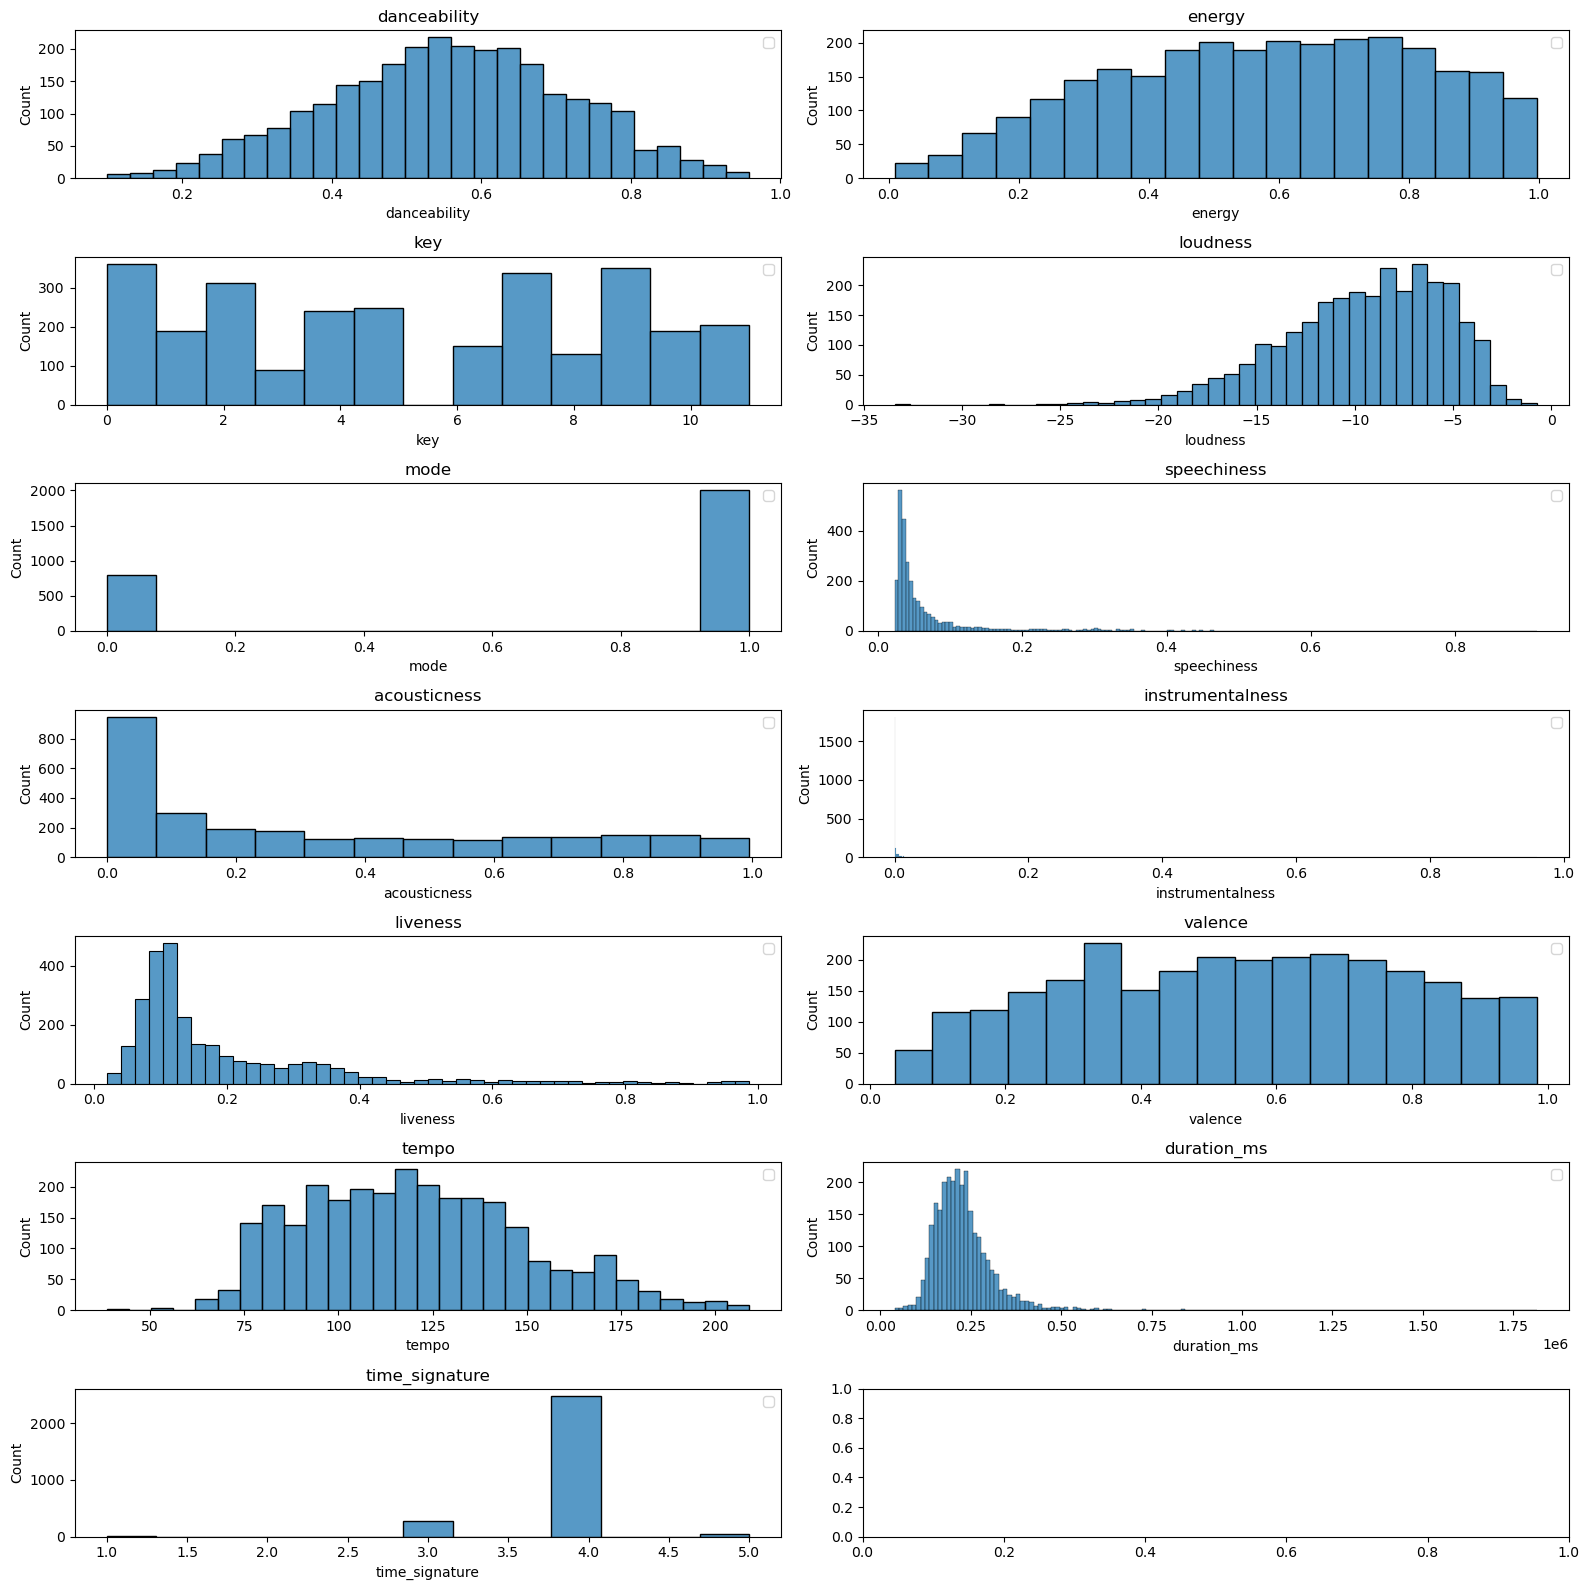

In [11]:
histogram_continuous(song_db.select_dtypes(np.number))

In [13]:
# selecting features for clustering
# The selected features are based on the distribution (graph above) and the descriptive statistics of all the audio features in this song_DB, and what we think that it makes sense when listening to a song
# we see time signature is quite imbalanced (more than 2000 points with time_sig around 4 in total ~2.8k songs)


song_cluster_df = song_db[['track_name', 'artist_name', 'song_id', 'danceability', 'energy', 'acousticness', 'key', 'valence', 'hotness']]

In [14]:
song_cluster_df

,track_name,artist_name,song_id,danceability,energy,acousticness,key,valence,hotness
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,0.614000,8,0.898,yes
1,All I Want For Christmas Is You,Mariah Carey,0bYg9bo50gSsH3LtXe2SQn,0.336,0.627,0.164000,7,0.350,yes
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,0.643000,2,0.806,yes
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,0.189000,2,0.947,yes
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0.579000,0,0.888,yes
...,...,...,...,...,...,...,...,...,...
2802,reckless life,guns n' roses,7I2Q7AQqVInZYwOoDHZGOf,0.442,0.888,0.000054,10,0.462,no
2803,pain and love,t. rex,5Qe7x9x8mfl2YcbYTP5yRM,0.588,0.629,0.055500,0,0.763,no
2804,brave new world,greta van fleet,0HwdiT4MVRzY0OALcjq0Oh,0.341,0.848,0.058300,7,0.589,no
2805,i-76,g. love & special sauce,40c4Zo0r2HH9aKDgEsbsVA,0.643,0.713,0.138000,11,0.492,no


In [15]:
X = song_cluster_df.iloc[:,-6:-1]
X

,danceability,energy,acousticness,key,valence
0,0.589,0.472,0.614000,8,0.898
1,0.336,0.627,0.164000,7,0.350
2,0.754,0.424,0.643000,2,0.806
3,0.735,0.478,0.189000,2,0.947
4,0.683,0.375,0.579000,0,0.888
...,...,...,...,...,...
2802,0.442,0.888,0.000054,10,0.462
2803,0.588,0.629,0.055500,0,0.763
2804,0.341,0.848,0.058300,7,0.589
2805,0.643,0.713,0.138000,11,0.492


In [16]:
# apply standard scaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "song_cluster_scaled.pkl" # Path with filename

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = song_cluster_df.columns[-6:-1])
display(song_cluster_df.head())
print()
display(X_scaled_df.head())

,track_name,artist_name,song_id,danceability,energy,acousticness,key,valence,hotness
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,0.614,8,0.898,yes
1,All I Want For Christmas Is You,Mariah Carey,0bYg9bo50gSsH3LtXe2SQn,0.336,0.627,0.164,7,0.350,yes
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,0.643,2,0.806,yes
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,0.189,2,0.947,yes
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0.579,0,0.888,yes


,danceability,energy,acousticness,key,valence
0,0.202830,-0.449753,0.890169,0.755360,1.463015
1,-1.374567,0.207510,-0.512959,0.474638,-0.775453
2,1.231567,-0.653293,0.980593,-0.928973,1.087214
3,1.113107,-0.424311,-0.435008,-0.928973,1.663170
4,0.788899,-0.861073,0.781037,-1.490418,1.422167


In [19]:
# apply standard scaler on all features

scaler = StandardScaler()
scaler.fit(num)
X_scaled_all = scaler.transform(num)
filename = "song_cluster_num_scaled.pickle" # Path with filename

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df_all = pd.DataFrame(X_scaled_all, columns = num.columns)
display(song_db.head())
print()
display(X_scaled_df_all.head())

,track_name,artist_name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,hotness
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.614,...,0.898,67.196,audio_features,2EjXfH91m7f8HiJN1yQg97,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,yes
1,All I Want For Christmas Is You,Mariah Carey,0bYg9bo50gSsH3LtXe2SQn,0.336,0.627,7,-7.463,1,0.0384,0.164,...,0.350,150.273,audio_features,0bYg9bo50gSsH3LtXe2SQn,spotify:track:0bYg9bo50gSsH3LtXe2SQn,https://api.spotify.com/v1/tracks/0bYg9bo50gSs...,https://api.spotify.com/v1/audio-analysis/0bYg...,241107,4,yes
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.643,...,0.806,119.705,audio_features,7vQbuQcyTflfCIOu3Uzzya,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,yes
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.189,...,0.947,107.682,audio_features,2FRnf9qhLbvw8fu4IBXx78,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,yes
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.579,...,0.888,140.467,audio_features,77khP2fIVhSW23NwxrRluh,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,yes


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.202830,-0.449753,0.755360,0.179130,0.633008,-0.251073,0.890169,-0.372896,1.834990,1.463015,-1.800208,-1.169584,0.260607
1,-1.374567,0.207510,0.474638,0.494131,0.633008,-0.407253,-0.512959,-0.372896,-0.745813,-0.775453,1.015000,0.143388,0.260607
2,1.231567,-0.653293,-0.928973,0.249184,0.633008,-0.435048,0.980593,-0.372896,-0.779099,1.087214,-0.020849,-1.115780,0.260607
3,1.113107,-0.424311,-0.928973,-0.732806,0.633008,-0.527698,-0.435008,-0.372884,0.943418,1.663170,-0.428270,0.393234,0.260607
4,0.788899,-0.861073,-1.490418,-0.875854,0.633008,-0.514462,0.781037,-0.372896,-0.714905,1.422167,0.682707,-1.063645,0.260607


# Dimensionality reduction 

### PCA

In [22]:
from sklearn.decomposition import PCA
# PCA 
pca = PCA()
pca.fit(X_scaled_df)
principal_components = pca.transform(X_scaled_df)
principal_components_df = pd.DataFrame(principal_components, columns=['PCA_'+ str(i) for i in range(1,X_scaled_df.shape[1]+1)])
principal_components_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,0.090738,-1.436484,0.693725,-1.089455,-0.083164
1,0.306191,1.583891,0.515529,-0.237850,-0.312130
2,0.169108,-1.982856,-0.972486,-0.119968,0.172337
3,-1.021805,-1.622143,-0.989511,-0.135305,-0.751353
4,0.188771,-1.865480,-1.536123,-0.495985,-0.310493


In [23]:
from sklearn.decomposition import PCA
# PCA 
pca_all = PCA()
pca_all.fit(X_scaled_df_all)
principal_components_all = pca_all.transform(X_scaled_df_all)
principal_components_df_all = pd.DataFrame(principal_components_all, columns=['PCA_'+ str(i) for i in range(1,X_scaled_df_all.shape[1]+1)])
principal_components_df_all.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
0,0.386594,-1.594286,-0.301752,1.306181,1.572134,0.083639,-1.481249,1.426049,-0.471853,-0.669679,0.607129,0.011780,-0.436940
1,-0.299843,1.471118,-0.823896,-0.356395,-0.881835,-0.628314,-0.746360,-0.595853,0.609856,0.239964,0.073775,-0.136044,-0.221505
2,0.559728,-2.111057,-1.306637,-0.628914,0.004125,-0.155859,0.318173,-0.060347,-0.233750,-0.178453,0.088947,0.718580,-0.221196
3,-0.056497,-1.381613,-0.480509,-0.551137,1.201974,0.584183,0.191659,1.064793,-0.851003,1.150754,-0.166990,-0.587596,-0.252602
4,1.049181,-1.976608,-1.714374,-0.832290,-0.204498,0.576388,0.488981,-0.400523,-0.563225,0.440339,0.109953,-0.160415,-0.060483


In [24]:
print(pca.explained_variance_ratio_)
print(pca_all.explained_variance_ratio_)

[0.3711268  0.27215297 0.19993453 0.10626688 0.05051883]
[0.20323254 0.12902363 0.10063591 0.08542525 0.08023629 0.07453917
 0.07094076 0.06462372 0.05942206 0.0573449  0.03181827 0.03161546
 0.01114203]


### insights:


regardless selecting a subset of features or using all features, with PCA, the  PC1,PC2 can only explain for approximately 64% of differences (variance)  using a subset and 32% using all within our data.
    

### ISOMAP

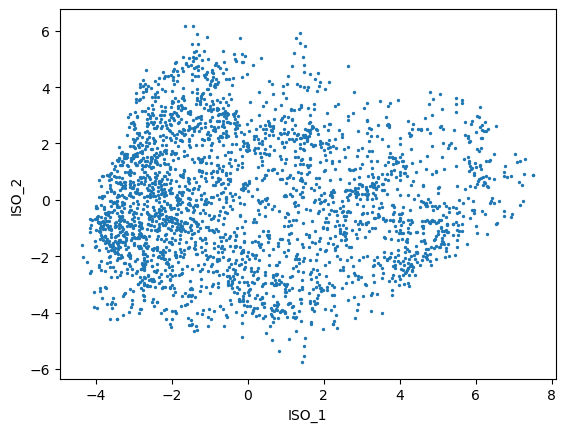

In [30]:
from sklearn.manifold import Isomap

# using a subset of features : dance, acoustic, key, energy, valence

iso = Isomap(n_neighbors=3, n_components=2)
iso.fit(X_scaled_df)
X_isomap_transformed = iso.transform(X_scaled_df)
X_isomap_transformed_df = pd.DataFrame(X_isomap_transformed, columns=["ISO_1","ISO_2"])
    #X_isomap_transformed_df.head()

fig, ax = plt.subplots()
ax.scatter(X_isomap_transformed_df['ISO_1'],X_isomap_transformed_df['ISO_2'], s=2)
ax.set_xlabel("ISO_1")
ax.set_ylabel("ISO_2")
plt.show()


In [ ]:
# insights: with n_neighbors = 3 or 4, can observe vaguely 4-6 clusters. But above that, all seem to merge

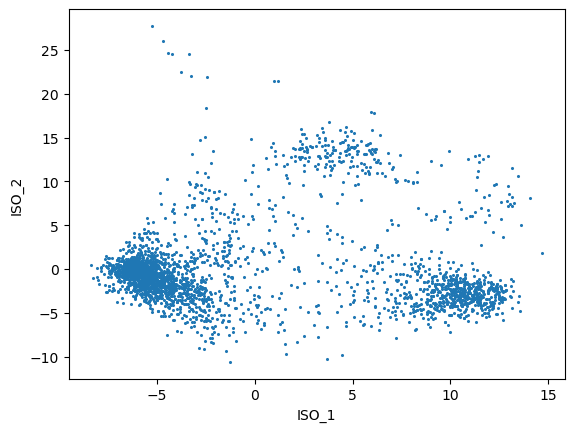

In [35]:
from sklearn.manifold import Isomap

# using all features
iso = Isomap(n_neighbors=4, n_components=2)
iso.fit(X_scaled_df_all)
X_isomap_transformed_all = iso.transform(X_scaled_df_all)
X_isomap_transformed_df_all = pd.DataFrame(X_isomap_transformed_all, columns=["ISO_1","ISO_2"])
    #X_isomap_transformed_df.head()

fig, ax = plt.subplots()
ax.scatter(X_isomap_transformed_df_all['ISO_1'],X_isomap_transformed_df_all['ISO_2'], s=1.5)
ax.set_xlabel("ISO_1")
ax.set_ylabel("ISO_2")
plt.show()


In [ ]:
# insights: interestingly, with all features, it looks like data clusters into 3 groups with different density

### UMAP

In [36]:
from umap import UMAP

# for the subset of features
reducer = UMAP(n_components=2,random_state=42)
reducer.fit(X_scaled_df)

X_umap_transformed = reducer.transform(X_scaled_df)
X_umap_transformed_df = pd.DataFrame(X_umap_transformed, columns=["UMAP_1","UMAP_2"])
X_umap_transformed_df.head()

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/umap/distances.py:1086: Num

,UMAP_1,UMAP_2
0,4.579453,8.801546
1,2.828866,4.308751
2,5.462591,7.344428
3,-3.485456,5.750309
4,5.353116,7.041760


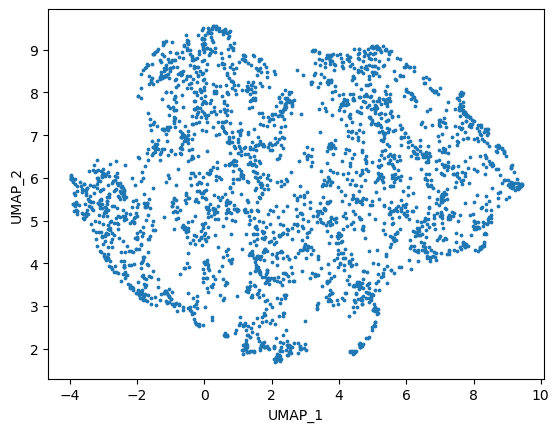

In [38]:
fig, ax = plt.subplots()
ax.scatter(X_umap_transformed_df['UMAP_1'],X_umap_transformed_df['UMAP_2'], s=3)
ax.set_xlabel("UMAP_1")
ax.set_ylabel("UMAP_2")
plt.show()

In [ ]:
# insights: with UMAP, 

In [39]:
from umap import UMAP

reducer_all = UMAP(n_components=2,random_state=42)
reducer_all.fit(X_scaled_df_all)

X_umap_transformed_all = reducer_all.transform(X_scaled_df_all)
X_umap_transformed_df_all = pd.DataFrame(X_umap_transformed_all, columns=["UMAP_1","UMAP_2"])
X_umap_transformed_df_all.head()

,UMAP_1,UMAP_2
0,11.427610,6.312251
1,9.470885,9.504123
2,11.802088,6.446541
3,11.193447,7.544545
4,11.656158,6.515220


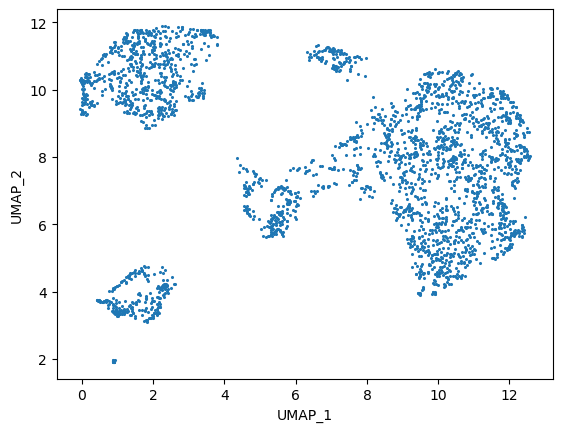

In [40]:
fig, ax = plt.subplots()
ax.scatter(X_umap_transformed_df_all['UMAP_1'],X_umap_transformed_df_all['UMAP_2'], s=1.5)
ax.set_xlabel("UMAP_1")
ax.set_ylabel("UMAP_2")
plt.show()

## Clustering with K-Means

In [41]:
from sklearn.cluster import KMeans


In [42]:
kmeans = KMeans(n_clusters=6,  random_state=1234)
kmeans.fit(X_scaled_df)

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=1234)

In [43]:
# save model:
path = "./"
filename = "KMeans_cluster.pkl"
with open(path+filename, "wb") as file:
    pickle.dump(kmeans, file)

In [45]:
clusters = kmeans.predict(X_scaled_df)
#clusters
song_db['cluster'] = clusters
pd.Series(clusters).value_counts().sort_index() # Number of wines in each cluster

0    441
1    559
2    492
3    427
4    430
5    458
Name: count, dtype: int64

In [52]:
song_db

,track_name,artist_name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,hotness,cluster
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.614000,...,67.196,audio_features,2EjXfH91m7f8HiJN1yQg97,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,yes,3
1,All I Want For Christmas Is You,Mariah Carey,0bYg9bo50gSsH3LtXe2SQn,0.336,0.627,7,-7.463,1,0.0384,0.164000,...,150.273,audio_features,0bYg9bo50gSsH3LtXe2SQn,spotify:track:0bYg9bo50gSsH3LtXe2SQn,https://api.spotify.com/v1/tracks/0bYg9bo50gSs...,https://api.spotify.com/v1/audio-analysis/0bYg...,241107,4,yes,5
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.643000,...,119.705,audio_features,7vQbuQcyTflfCIOu3Uzzya,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,yes,3
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.189000,...,107.682,audio_features,2FRnf9qhLbvw8fu4IBXx78,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,yes,0
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.579000,...,140.467,audio_features,77khP2fIVhSW23NwxrRluh,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,yes,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,reckless life,guns n' roses,7I2Q7AQqVInZYwOoDHZGOf,0.442,0.888,10,-8.820,0,0.0663,0.000054,...,108.024,audio_features,7I2Q7AQqVInZYwOoDHZGOf,spotify:track:7I2Q7AQqVInZYwOoDHZGOf,https://api.spotify.com/v1/tracks/7I2Q7AQqVInZ...,https://api.spotify.com/v1/audio-analysis/7I2Q...,200600,4,no,5
2803,pain and love,t. rex,5Qe7x9x8mfl2YcbYTP5yRM,0.588,0.629,0,-10.226,0,0.0318,0.055500,...,136.091,audio_features,5Qe7x9x8mfl2YcbYTP5yRM,spotify:track:5Qe7x9x8mfl2YcbYTP5yRM,https://api.spotify.com/v1/tracks/5Qe7x9x8mfl2...,https://api.spotify.com/v1/audio-analysis/5Qe7...,221440,4,no,0
2804,brave new world,greta van fleet,0HwdiT4MVRzY0OALcjq0Oh,0.341,0.848,7,-4.475,1,0.0371,0.058300,...,136.568,audio_features,0HwdiT4MVRzY0OALcjq0Oh,spotify:track:0HwdiT4MVRzY0OALcjq0Oh,https://api.spotify.com/v1/tracks/0HwdiT4MVRzY...,https://api.spotify.com/v1/audio-analysis/0Hwd...,300880,4,no,5
2805,i-76,g. love & special sauce,40c4Zo0r2HH9aKDgEsbsVA,0.643,0.713,11,-6.716,0,0.2150,0.138000,...,103.942,audio_features,40c4Zo0r2HH9aKDgEsbsVA,spotify:track:40c4Zo0r2HH9aKDgEsbsVA,https://api.spotify.com/v1/tracks/40c4Zo0r2HH9...,https://api.spotify.com/v1/audio-analysis/40c4...,225640,4,no,1


In [47]:
# save song_db with KMeans cluster prediction
song_db.to_csv('song_db_cluster.csv', index=False)

In [48]:
# check Kmeans model for all audio features
kmeans_all = KMeans(n_clusters=5,  random_state=1234)
kmeans_all.fit(X_scaled_df_all)

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=1234)

In [49]:
clusters_all = kmeans_all.predict(X_scaled_df_all)
#clusters
pd.Series(clusters_all).value_counts().sort_index() # Number of wines in each cluster

0    205
1    916
2    197
3    843
4    646
Name: count, dtype: int64

In [42]:
#X_df = pd.DataFrame(X)
X["cluster"] = clusters
X.head()

,danceability,energy,acousticness,key,valence,cluster
0,0.589,0.472,0.614,8,0.898,2
1,0.336,0.627,0.164,7,0.350,0
2,0.754,0.424,0.643,2,0.806,2
3,0.735,0.478,0.189,2,0.947,3
4,0.683,0.375,0.579,0,0.888,2


In [51]:
# check metrics for both 5 features (X_scaled_df) and all features (X_scaled_df_all)
print('inertia for model_5: ', kmeans.inertia_, '\n and for model_all: ',kmeans_all.inertia_ )
print('silhouete_score for model_5: ', silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)), '\n and for model_all: ', silhouette_score(X_scaled_df_all, kmeans_all.predict(X_scaled_df_all)))
print('CH_score for model_5: ', calinski_harabasz_score(X_scaled_df, kmeans.predict(X_scaled_df)), '\n and for model_all: ', calinski_harabasz_score(X_scaled_df_all, kmeans_all.predict(X_scaled_df_all)) )


inertia for model_5:  5893.20429323692 
 and for model_all:  25285.721985174285
silhouete_score for model_5:  0.20877647758023424 
 and for model_all:  0.11984302833304687
CH_score for model_5:  773.963747112856 
 and for model_all:  310.42484115109227


Training a K-Means model with 2 clusters! 

Initialization complete
Iteration 0, inertia 19773.62580172617.
Iteration 1, inertia 10891.95699497881.
Iteration 2, inertia 10451.62302998887.
Iteration 3, inertia 10295.14853969997.
Iteration 4, inertia 10260.76066586587.
Iteration 5, inertia 10255.303257331117.
Iteration 6, inertia 10254.120851213102.


/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 7, inertia 10253.950764324425.
Converged at iteration 7: center shift 5.361179128818512e-06 within tolerance 0.00010000000000000049.
Initialization complete
Iteration 0, inertia 18782.89877800697.
Iteration 1, inertia 10437.583701466432.
Iteration 2, inertia 10272.718189924337.
Iteration 3, inertia 10256.40523272342.
Iteration 4, inertia 10254.383571460952.
Iteration 5, inertia 10254.026214000973.
Converged at iteration 5: center shift 6.487246498791617e-05 within tolerance 0.00010000000000000049.
Initialization complete
Iteration 0, inertia 15983.541727792832.
Iteration 1, inertia 10514.169718750272.
Iteration 2, inertia 10346.19899909364.
Iteration 3, inertia 10290.129868755172.
Iteration 4, inertia 10269.39786028913.
Iteration 5, inertia 10258.703927619286.
Iteration 6, inertia 10255.733322685828.
Iteration 7, inertia 10254.263732099458.
Iteration 8, inertia 10253.90597108191.
Converged at iteration 8: center shift 1.8424665167017846e-05 within tolerance 0.0001000000000000

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training a K-Means model with 4 clusters! 

Initialization complete
Iteration 0, inertia 12215.130151675803.
Iteration 1, inertia 7647.081816560764.
Iteration 2, inertia 7532.527088515477.
Iteration 3, inertia 7512.133149704027.
Iteration 4, inertia 7504.486008625202.
Iteration 5, inertia 7499.250581715791.
Iteration 6, inertia 7493.381318501688.
Iteration 7, inertia 7484.341791528033.
Iteration 8, inertia 7469.161394168159.
Iteration 9, inertia 7447.757955077981.
Iteration 10, inertia 7426.0210926484.
Iteration 11, inertia 7411.845156176532.
Iteration 12, inertia 7398.925246897868.
Iteration 13, inertia 7383.169890418481.
Iteration 14, inertia 7370.396282294117.
Iteration 15, inertia 7363.856970349565.
Iteration 16, inertia 7357.320659890018.
Iteration 17, inertia 7351.807157844144.
Iteration 18, inertia 7346.632862032791.
Iteration 19, inertia 7342.138961459221.
Iteration 20, inertia 7338.830349474425.
Iteration 21, inertia 7336.621574138882.
Iteration 22, inertia 7335.751967148993.


/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 13471.910725630078.
Iteration 1, inertia 7608.029607670218.
Iteration 2, inertia 7255.286054981057.
Iteration 3, inertia 7175.051021991971.
Iteration 4, inertia 7154.876089359785.
Iteration 5, inertia 7148.377867405712.
Iteration 6, inertia 7144.611410119065.
Iteration 7, inertia 7142.3107983181.
Iteration 8, inertia 7141.113271849607.
Iteration 9, inertia 7140.762759140091.
Iteration 10, inertia 7140.495812533523.
Converged at iteration 10: center shift 8.826205398051413e-05 within tolerance 0.00010000000000000049.
Initialization complete
Iteration 0, inertia 10893.408837293753.
Iteration 1, inertia 8500.549077721178.
Iteration 2, inertia 8128.209937215757.
Iteration 3, inertia 7752.229152976285.
Iteration 4, inertia 7529.364280267931.
Iteration 5, inertia 7444.02078085599.
Iteration 6, inertia 7389.060542085885.
Iteration 7, inertia 7356.480362636416.
Iteration 8, inertia 7340.45401597251.
Iteration 9, inertia 7333.868637047912.
Iteration 

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 26, inertia 6456.8907161275065.
Iteration 27, inertia 6454.724997123657.
Iteration 28, inertia 6453.538977764099.
Iteration 29, inertia 6451.092685197238.
Iteration 30, inertia 6446.949787305122.
Iteration 31, inertia 6445.0997626569715.
Iteration 32, inertia 6444.32298106044.
Iteration 33, inertia 6443.212337362486.
Iteration 34, inertia 6442.2938848067215.
Iteration 35, inertia 6441.858023847206.
Iteration 36, inertia 6441.762362051663.
Converged at iteration 36: center shift 4.616266955314054e-05 within tolerance 0.00010000000000000049.
Initialization complete
Iteration 0, inertia 10060.499571294094.
Iteration 1, inertia 7016.51323541352.
Iteration 2, inertia 6741.448540128618.
Iteration 3, inertia 6670.053707778831.
Iteration 4, inertia 6632.299338041455.
Iteration 5, inertia 6605.7580924761805.
Iteration 6, inertia 6586.936257010979.
Iteration 7, inertia 6571.181184555002.
Iteration 8, inertia 6562.378029417202.
Iteration 9, inertia 6556.882478202981.
Iteration 10, inert

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 0, inertia 8559.870743100892.
Iteration 1, inertia 6514.792168330363.
Iteration 2, inertia 6221.767625661781.
Iteration 3, inertia 6092.375255283456.
Iteration 4, inertia 6037.472427610255.
Iteration 5, inertia 6010.149401546588.
Iteration 6, inertia 5986.712625465457.
Iteration 7, inertia 5964.453477448851.
Iteration 8, inertia 5952.398804801296.
Iteration 9, inertia 5944.2567260260985.
Iteration 10, inertia 5940.4692155104385.
Iteration 11, inertia 5939.5950453269115.
Iteration 12, inertia 5939.49621498356.
Converged at iteration 12: center shift 8.239938693774364e-05 within tolerance 0.00010000000000000049.
Training a K-Means model with 7 clusters! 

Initialization complete
Iteration 0, inertia 7948.2530613738645.
Iteration 1, inertia 5921.618689920916.
Iteration 2, inertia 5769.786716101167.
Iteration 3, inertia 5728.8294716062555.
Iteration 4, inertia 5711.354774954372.
Iteration 5, inertia 5703.849071394687.
Iteration 6, inertia 5698.486189210437.
Iteration 7, inertia 5

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 19, inertia 5493.252664171743.
Iteration 20, inertia 5492.765904641985.
Iteration 21, inertia 5492.43918583799.
Iteration 22, inertia 5492.166753780923.
Iteration 23, inertia 5491.769060791057.
Iteration 24, inertia 5491.500031670785.
Iteration 25, inertia 5491.438016790846.
Iteration 26, inertia 5491.3580434404485.
Converged at iteration 26: center shift 8.982477389856546e-05 within tolerance 0.00010000000000000049.
Initialization complete
Iteration 0, inertia 7555.907964895404.
Iteration 1, inertia 5948.291213160364.
Iteration 2, inertia 5690.474780189442.
Iteration 3, inertia 5620.517713940695.
Iteration 4, inertia 5597.294163700923.
Iteration 5, inertia 5589.98962166845.
Iteration 6, inertia 5585.5510664489575.
Iteration 7, inertia 5583.465843466365.
Iteration 8, inertia 5581.744897466598.
Iteration 9, inertia 5579.966110406355.
Iteration 10, inertia 5578.445150181493.
Iteration 11, inertia 5577.3475062242305.
Iteration 12, inertia 5576.358987626857.
Iteration 13, inertia

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 16, inertia 5145.576549770075.
Iteration 17, inertia 5142.9185554905.
Iteration 18, inertia 5141.467507018759.
Iteration 19, inertia 5139.979508279639.
Iteration 20, inertia 5138.232129439765.
Iteration 21, inertia 5137.346732781477.
Iteration 22, inertia 5135.791744210639.
Iteration 23, inertia 5133.638677912231.
Iteration 24, inertia 5132.743459083271.
Iteration 25, inertia 5132.099363519323.
Iteration 26, inertia 5131.623157776049.
Iteration 27, inertia 5131.18584132007.
Iteration 28, inertia 5130.344382650853.
Iteration 29, inertia 5129.5493067996285.
Iteration 30, inertia 5128.1585032304465.
Iteration 31, inertia 5125.366185624903.
Iteration 32, inertia 5121.133707800749.
Iteration 33, inertia 5115.1687783901925.
Iteration 34, inertia 5109.070300176684.
Iteration 35, inertia 5105.4242304133995.
Iteration 36, inertia 5103.276506261871.
Iteration 37, inertia 5102.539883838089.
Iteration 38, inertia 5101.554192481881.
Iteration 39, inertia 5101.085983908355.
Iteration 40, i

/Users/minhnguyen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 2, inertia 5328.385218003973.
Iteration 3, inertia 5244.379050981051.
Iteration 4, inertia 5112.288160028616.
Iteration 5, inertia 4969.899803803361.
Iteration 6, inertia 4916.61074244845.
Iteration 7, inertia 4899.787752592664.
Iteration 8, inertia 4891.530726266986.
Iteration 9, inertia 4882.740147294509.
Iteration 10, inertia 4871.877432575268.
Iteration 11, inertia 4863.389891714483.
Iteration 12, inertia 4859.806236579708.
Iteration 13, inertia 4857.56869494709.
Iteration 14, inertia 4856.6515098334485.
Iteration 15, inertia 4855.810152186518.
Iteration 16, inertia 4854.273881340786.
Iteration 17, inertia 4852.853835635389.
Iteration 18, inertia 4851.939005491583.
Iteration 19, inertia 4851.410278998141.
Iteration 20, inertia 4851.0486059160085.
Iteration 21, inertia 4850.925780078773.
Iteration 22, inertia 4850.843602578247.
Converged at iteration 22: center shift 9.239714627095499e-05 within tolerance 0.00010000000000000049.
Initialization complete
Iteration 0, inertia

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

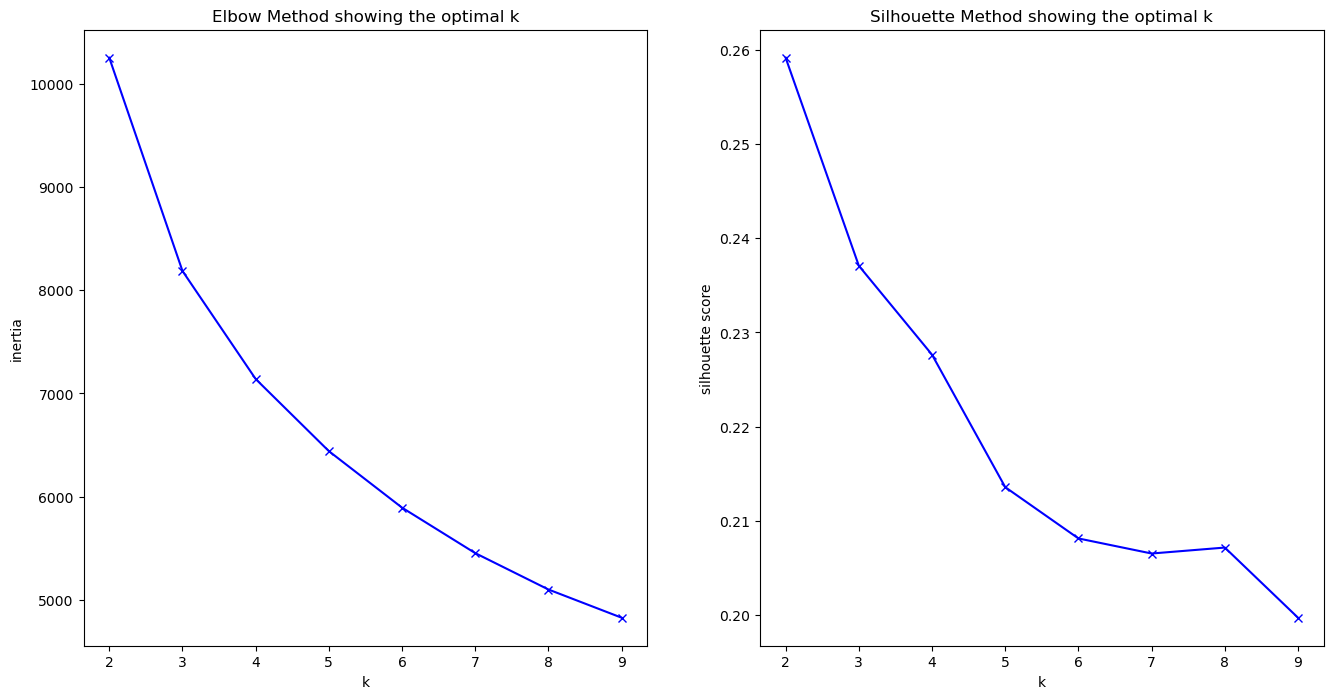

In [23]:
# checking optimal k value

K = range(2, 10)

inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,init='k-means++',
                    random_state=1234,
                    verbose=1)
    kmeans.fit(X_scaled_df)

    filename = "kmeans_" + str(k) + ".pickle" # Path with filename # kmeans_n.pickle
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

# Clustering 

### DBSCAN

In [83]:
X_umap_transformed_df

,UMAP_1,UMAP_2
0,4.579453,8.801546
1,2.828866,4.308751
2,5.462591,7.344428
3,-3.485456,5.750309
4,5.353116,7.041760
...,...,...
2802,1.331817,5.115801
2803,-2.792077,4.772334
2804,0.692306,4.321947
2805,1.635945,6.390665


In [137]:
# Creating the clustering model
model = DBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat = model.fit_predict(X_scaled_df) # .fit(X_scaled_df)

In [138]:
yhat

array([-1, -1,  4, ...,  0,  0, -1])

In [139]:
X_scaled_df['dbscan_cluster'] = yhat

In [140]:
X_scaled_df.dbscan_cluster.value_counts()

dbscan_cluster
-1     1757
 0      730
 18      21
 3       17
 1       17
 22      14
 11      11
 6       11
 21      11
 9        9
 8        9
 15       9
 2        8
 12       7
 19       7
 36       7
 24       7
 10       6
 14       6
 20       6
 42       6
 45       5
 38       5
 26       5
 27       5
 33       5
 31       5
 28       5
 7        5
 30       5
 46       5
 5        5
 43       5
 40       5
 13       5
 47       5
 4        5
 34       5
 23       5
 29       5
 37       5
 44       5
 39       4
 16       4
 17       4
 41       4
 32       4
 25       3
 35       3
Name: count, dtype: int64

In [1]:
from sklearn.cluster import HDBSCAN

In [3]:
# Creating the clustering model
model = HDBSCAN(eps = 1.0, min_samples=9) # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat = model.fit_predict(X_scaled_df) # .fit(X_scaled_df)

TypeError: HDBSCAN.__init__() got an unexpected keyword argument 'eps'

In [193]:
yhat

array([0, 0, 0, ..., 0, 0, 0])

In [194]:
X_scaled_df['dbscan_cluster'] = yhat

In [195]:
X_scaled_df.dbscan_cluster.value_counts()

dbscan_cluster
 0    2679
-1      32
 6      23
 5      21
 3      16
 1      14
 2      11
 4      11
Name: count, dtype: int64

In [119]:
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

neighbors = 10 # The value of MinPoints or mins_samples = 2 * number_of_columns
# X_embedded is your data
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X_scaled_df)
distances, indices = nbrs.kneighbors(X_scaled_df)
print("The 'distances' array is an 2D-array containing as many rows as points and as many columns as mins_samples", distances.shape)
distance_desc = sorted(distances[:,neighbors-1], reverse=True)
fig = px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc).update_layout(
    xaxis_title="Array index", yaxis_title="Distance"
)
fig.add_hline(y=0.5, annotation_text="Default value of epsilon in DBSCAN")
fig.show()

The 'distances' array is an 2D-array containing as many rows as points and as many columns as mins_samples (2807, 10)


In [120]:
kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure (see https://mmerevise.co.uk/a-level-maths-revision/convex-and-concave-curves/)
                      direction="decreasing") #parameter from figure

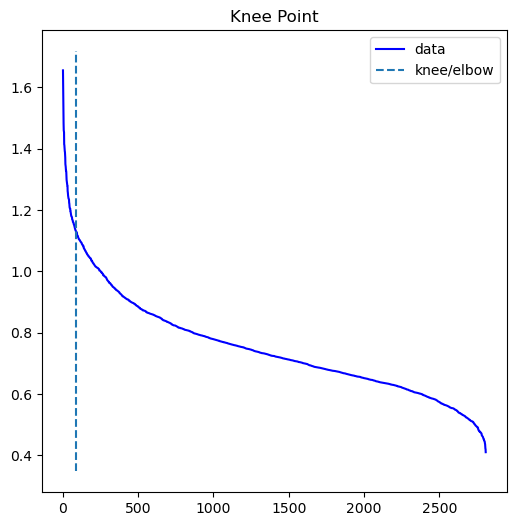

In [121]:
kneedle.plot_knee()

In [122]:
print("The epsilon value for which the distance plot has the biggest change in the slope is: {:.2f}".format(kneedle.knee_y))

The epsilon value for which the distance plot has the biggest change in the slope is: 1.13


In [127]:
X_scaled_df.drop(columns='dbscan_1.05', inplace=True)

In [129]:
X_scaled_df_ep= X_scaled_df.copy()

In [132]:
models = {}
epsilons = []
silhouettes = []
dbcvs = []

# Epsilon values to use (including the optimal found 0.49 with the kneed library)
for value in np.arange(1.05, 1.2, 0.01):
    epsilons.append(value)
    print("Clustering with epsilon {:.2f}".format(value))
    model = DBSCAN(eps=value, min_samples=10) # min_samples = 2 * #features
    # fit model and predict clusters
    yhat_ep = model.fit_predict(X_scaled_df_ep)
    X_scaled_df_ep["dbscan_"+str(round(value,2))] = yhat_ep

    # Scores
    print("======================================================")
    #print("Evaluating the clustering with the silhoette score...")
    print()
    sil_score =  round(silhouette_score(X_scaled_df_ep, yhat_ep, metric='euclidean'),2)
    print("The silhouette score is {:.2f}".format(sil_score))
    silhouettes.append(sil_score)
    #print("Evaluating the clustering with the DBVC score...")
    #start_time = time.time()
    try:
        dbcv_score = round(DBCV(X_scaled_df_ep.to_numpy(), yhat_ep, dist_function=euclidean))
        print("The DBCV score is {:.2f}".format(dbcv_score))
        dbcvs.append(dbcv_score)
    except:
        print("The DBCV score calculation failed")
        dbcvs.append(np.nan)
    print("======================================================")
    #ending_time = time.time()
    #print("The clustering evaluation with the DBCV score took {:.2f} seconds".format(ending_time-start_time))
    models["model_ep"+str(round(value,2))] = {"model":model,"yhat": yhat_ep, "silhouette_score": sil_score,
                                            "DBCV_score": dbcv_score}
    print()
    print()

Clustering with epsilon 1.05

The silhouette score is 0.20
The DBCV score calculation failed


NameError: name 'dbcv_score' is not defined

In [91]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_scaled_df, yhat),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_scaled_df, yhat)),2)

The Silhouette score of the model is:  -0.46
The Calinksi-Harabasz score of the model is:  17 2


In [197]:
# Creating the clustering model
model_all = DBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat_all = model_all.fit_predict(X_umap_transformed_df_all) # .fit(X_scaled_df)

In [198]:
yhat_all

array([0, 0, 0, ..., 0, 2, 0])

In [199]:
X_scaled_df_all['dbscan_cluster'] = yhat_all

In [200]:
X_scaled_df_all.dbscan_cluster.value_counts()

dbscan_cluster
0    1783
2     662
1     243
4     103
3      16
Name: count, dtype: int64

In [102]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_umap_transformed_df_all, model_all.fit_predict(X_umap_transformed_df_all)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_umap_transformed_df_all, model_all.fit_predict(X_umap_transformed_df_all)),2))

The Silhouette score of the model is:  0.43
The Calinksi-Harabasz score of the model is:  2661.44


In [51]:
yhat

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X_df['dbscan_clusters'] = yhat
X_df.head()

In [ ]:
# retrieve unique clusters
clusters = np.unique(yhat)
clusters # DBSCAN flags with "-1" noisy data.

In [ ]:
[cluster for cluster in list(clusters) if cluster != -1]

In [ ]:
# Number of clusters (excluding noise points)
clusters.size - 1

In [ ]:
X_scaled_df["cluster"] = yhat
# Creating a pallette of hihg contrast colors with as many color as cluster labels
custom_palette = sns.color_palette(cc.glasbey, n_colors=clusters.size)
# Modifiying the palette to set the color "black=(0.,0.,0.)" to the label "-1" #(R,G,B)
custom_palette = [color if cluster != -1 else (0.,0.,0.) for cluster, color in zip(clusters,custom_palette)]
sns.scatterplot(X_scaled_df, x="X1", y="X2", hue="cluster", palette=custom_palette);
plt.show()